In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# Step-1: run TD query and download data to local

In [4]:
query1 = '''
-- time range from 2019-08-12 to 2019-09-05
-- pull the position performance and metrics data
select pos, source_type, tid, is_pb,
       sum(impression) as total_impression, 
       sum(gmv) as total_gmv, 
       sum(add_to_cart) as total_addtocart_freq,
       sum(transaction) as total_transaction,
       sum(click_frontend) as total_click_frontend, 
       sum(click_backend) as total_click_backend
from search.daily_feed_position_metrics
where date_str >= "2019-09-01" 
      and date_str <= "2019-09-08"
--      and is_pb = 0
      and tid IN (234,15,235,1713,266,1630,230,352,20023)
      and invalid_session != 1
group by pos, source_type, tid, is_pb
'''

query2 = '''
select 
--     td_time_format(td_date_trunc('day', cast(show_time as bigint)), 'yyyy-MM-dd') as impression_day
     cid,
     boost_source,
     tid,
     category_id,
     feed_id,
     client,
     country_code,
     pos,
     count(request_id) as impression
  from (select * 
        from product_boost.daily_impression_truelog TABLESAMPLE(10 PERCENT)
        ) as d
  where td_time_range(time, '2019-09-05', '2019-09-06','PDT')
        and likely_bot = 'false'
        and isnotnull(tid)
        and isnotnull(pos)
--          and tid IN (234,15,235,1713,266,1630,230,352,20023)
  group by 1,2,3,4,5,6,7,8
  ) as i

left join
(
select 
--  distinct 
--  td_time_format(td_date_trunc('month', cast(time as bigint)), 'yyyy-MM-dd') as product_month,
    product_id,
    count(product_id) as epc_freq
from 
   sweeper.epc_product_warehouse_status 
where 
   (next_east = 'true' or next_south = 'true' or cur_south = 'true' or cur_east='true')
and
    td_time_range(time, '2019-09-01', '2019-09-08','PDT')
group by product_id
) as e

on i.cid = e.product_id

group by
       i.boost_source,
       i.tid,
       i.category_id,
       i.feed_id,
       i.client,
       i.country_code,
       i.pos
'''

query3 = '''
-- pull data from phash for similar prod groups

'''

In [5]:
!pwd

/Users/zzhang/Desktop/version_control/EPC_prod_boost


In [12]:
df_imp_epc = pd.read_csv("/Users/zzhang/Desktop/impression_epc.csv")
df_imp_epc.head(5)

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression
0,NaN,5,NaN,NaN,NaN,AL,1,4,2
1,NaN,5,NaN,NaN,NaN,AL,17,4,2
2,NaN,5,NaN,NaN,NaN,AL,21,4,4
3,NaN,5,NaN,NaN,NaN,AR,39,112,37
4,NaN,5,NaN,NaN,NaN,AR,43,110,37


In [7]:
df_pos = pd.read_csv("/Users/zzhang/Desktop/position_metrics.csv")
df_pos.head(5)

,pos,source_type,tid,is_pb,total_impression,total_gmv,total_addtocart_freq,total_transaction,total_click_frontend,total_click_backend
0,0,latest,266,0,75096941,684218.105115,465197.0,92852.0,3439914.0,3555531.0
1,0,latest,266,1,22152879,203114.506346,100086.0,15597.0,1020232.0,1019109.0
2,0,latest,1713,0,152524,725.755701,486.0,100.0,3341.0,3557.0
3,0,latest,1713,1,48401,37.469825,67.0,7.0,737.0,766.0
4,0,others,266,0,6,NaN,NaN,NaN,NaN,NaN


In [8]:
df_imp_epc.describe()

,boost_source,tid,pos,impression,epc_impression
count,7338830.0,2.540174e+07,2.540174e+07,2.540174e+07,2.540174e+07
mean,3.0,1.502786e+03,9.290895e+02,1.478410e+02,7.206347e+01
std,0.0,1.053637e+03,1.188282e+03,5.465765e+03,2.833918e+03
min,3.0,5.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.0,1.583000e+03,1.450000e+02,1.000000e+00,0.000000e+00
50%,3.0,1.713000e+03,4.960000e+02,2.000000e+00,1.000000e+00
75%,3.0,1.713000e+03,1.255000e+03,7.000000e+00,3.000000e+00
max,3.0,3.060400e+04,1.673900e+04,7.096489e+06,3.904060e+06


In [9]:
df_imp_epc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25401740 entries, 0 to 25401739
Data columns (total 9 columns):
boost_source      float64
tid               int64
category_id       object
feed_id           object
client            object
country_code      object
pos               int64
impression        int64
epc_impression    int64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.7+ GB


In [10]:
df_imp_epc.shape

(25401740, 9)

# Step-2: Prepare the data

In [13]:
def imp_category(tid):
    if (tid in [234,15,235]):
        imp_category = 'search'
    elif (tid in [1713,266,1630,230,352,20023]):
        imp_category = 'feed'
    else:
        imp_category = 'irrelative'
    return imp_category

In [14]:
df_imp_epc['imp_category'] = df_imp_epc['tid'].apply(imp_category)
df_imp_epc.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative


In [15]:
def rank_category(pos):
    if (pos >=0 and pos <=100):
        rank_category = 'Good'
    elif (pos >=101 and pos <=500):
        rank_category = 'OK'
    else:
        rank_category = 'Not_good'
    return rank_category

In [16]:
df_imp_epc['rank_category'] = df_imp_epc['pos'].apply(rank_category)
df_imp_epc.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category,rank_category
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative,Good
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative,Good
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative,Good
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative,Good
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative,Good


In [17]:
df_imp_epc['is_epc_covered'] = df_imp_epc['epc_impression'].apply(lambda x : 1 if x >= 1 else 0)

In [18]:
df_imp_epc['is_pb'] = df_imp_epc['boost_source'].apply(lambda x : 1 if x >= 1 else 0)

In [19]:
df_imp_epc.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category,rank_category,is_epc_covered,is_pb
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative,Good,1,0
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative,Good,1,0
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative,Good,1,0
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative,Good,1,0
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative,Good,1,0


# Step-3: General Wish impression distribution analysis

### 75% impression traffic is from non-PB

In [20]:
df_imp_epc_groupby_is_pb = df_imp_epc.groupby(['is_pb'])

In [21]:
data = pd.DataFrame(df_imp_epc_groupby_is_pb.impression.sum())
data['overall_impression'] = df_imp_epc.impression.sum()
data['dist%'] = round(100*data.impression/data.overall_impression,2)
#data.reset_index(drop=False, inplace=True)
data

,impression,overall_impression,dist%
is_pb,,,
0,2819710051,3755419439,75.08
1,935709388,3755419439,24.92


In [22]:
df_imp_epc_groupby_imp_category = df_imp_epc[df_imp_epc["is_pb"]==0].groupby('imp_category')

In [23]:
data2 = pd.DataFrame(df_imp_epc_groupby_imp_category.impression.sum())
data2['overall_impression'] = df_imp_epc[df_imp_epc["is_pb"]==0].impression.sum()
data2['dist%'] = round(100*data2.impression/data2.overall_impression,2)
data2

,impression,overall_impression,dist%
imp_category,,,
feed,1402581340,2819710051,49.74
irrelative,662034163,2819710051,23.48
search,755094548,2819710051,26.78


### There are around 27% impression traffic from organic search
### There are around 50% impressions from feed

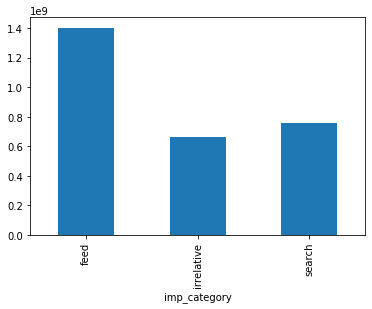

In [24]:
data2.impression.plot(kind='bar')

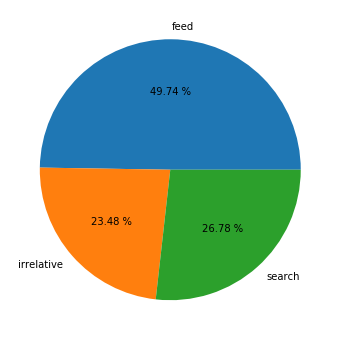

In [25]:
plt.figure(figsize=(6, 6))
fracs = data2['dist%']
labels = ['feed', 'irrelative', 'search']
plt.pie(fracs, labels=labels, autopct='%.2f %%')
plt.show()

## Impression distribution per tile position drop exponentially with a flat and long tail. 

In [26]:
df_imp_epc_groupby_pos = df_imp_epc[df_imp_epc["is_pb"]==0].groupby('pos')

In [27]:
data2 = pd.DataFrame(df_imp_epc_groupby_pos.impression.sum())
data2.reset_index(drop=False,inplace=True)
data2['overall_impression']=df_imp_epc.impression.sum()
data2['dist%'] = round(100*data2.impression/data2.overall_impression,2)
data2.head(10)

,pos,impression,overall_impression,dist%
0,0,62766969,3755419439,1.67
1,1,52710162,3755419439,1.40
2,2,57174688,3755419439,1.52
3,3,50107683,3755419439,1.33
4,4,38232460,3755419439,1.02
5,5,35605492,3755419439,0.95
6,6,25285090,3755419439,0.67
7,7,27113730,3755419439,0.72
8,8,24455376,3755419439,0.65
9,9,25893233,3755419439,0.69


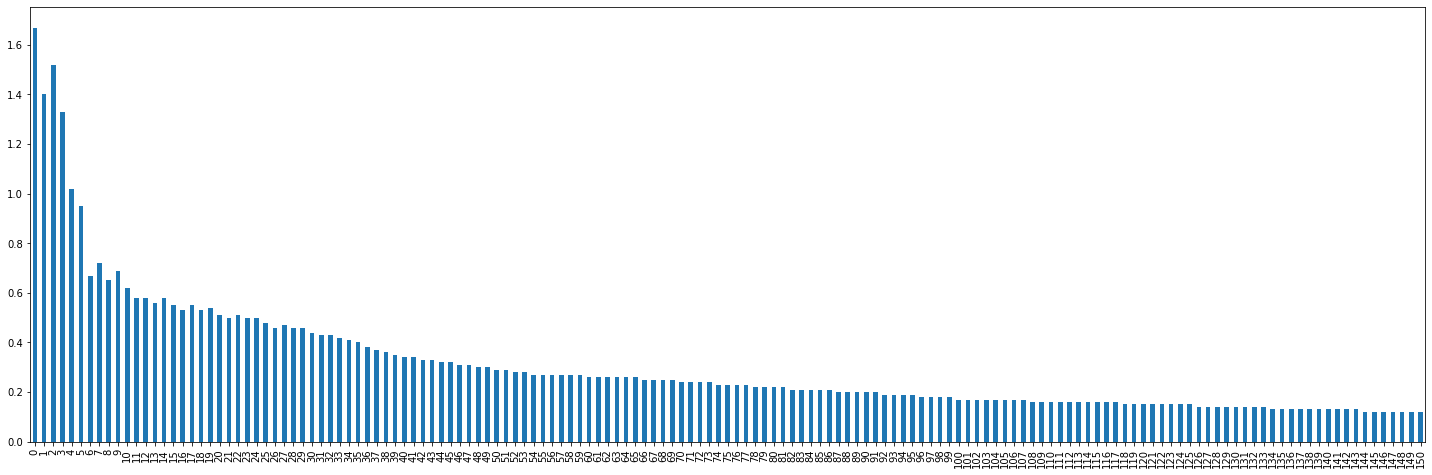

In [28]:
plt.figure(figsize=(25, 8))
mask = (data2['pos']>=0) & (data2['pos']<=150)
data2.loc[mask,'dist%'].plot(kind='bar')

# Step-4:Overall EPC impression analysis

### Within one day traffic, EPC product shows on 52% of all impressions

In [29]:
df_imp_epc2 = df_imp_epc[df_imp_epc["is_pb"]==0]
#df_imp_epc2.impression.sum()

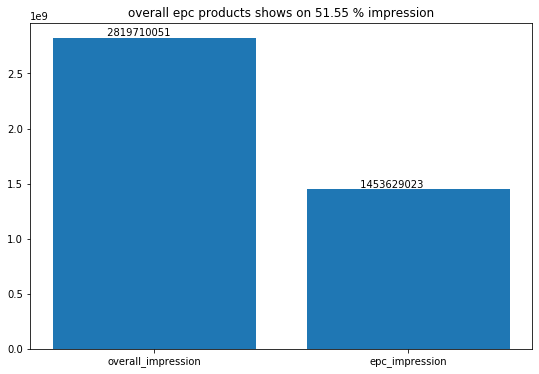

In [30]:
names = ["overall_impression","epc_impression"]
plt.figure(figsize=(9, 6))
plt.bar(names,[df_imp_epc[df_imp_epc["is_pb"]==0].impression.sum(),df_imp_epc[df_imp_epc["is_pb"]==0].epc_impression.sum()])
perc = str(round(100*df_imp_epc[df_imp_epc["is_pb"]==0].epc_impression.sum()/df_imp_epc[df_imp_epc["is_pb"]==0].impression.sum(),2))
plt.title('overall epc products shows on %s %% impression' %perc)
for i, v in enumerate([df_imp_epc[df_imp_epc["is_pb"]==0].impression.sum(),df_imp_epc[df_imp_epc["is_pb"]==0].epc_impression.sum()]):
    plt.text(i-0.2,v*1.01," "+str(v))
plt.show()

### Within one day traffic, there are 30% tiles do not show any EPC product in overal. 

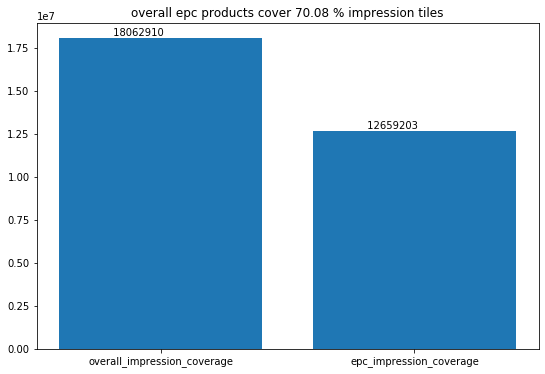

In [31]:
names = ["overall_impression_coverage","epc_impression_coverage"]
plt.figure(figsize=(9, 6))
plt.bar(names,[df_imp_epc2.is_epc_covered.count(),df_imp_epc2.is_epc_covered.sum()])
perc = str(round(100*df_imp_epc2.is_epc_covered.sum()/df_imp_epc2.is_epc_covered.count(),2))
plt.title('overall epc products cover %s %% impression tiles' %perc)
for i, v in enumerate([df_imp_epc2.is_epc_covered.count(),df_imp_epc2.is_epc_covered.sum()]):
    plt.text(i-0.2,v*1.01," "+str(v))
plt.show()

# Step-5: Further analysis by impression category

In [218]:
#data3 = pd.DataFrame({'overall_impression_coverage': df_imp_epc_groupby_imp_category.is_epc_covered.count()})
#data3.reset_index(drop=False, inplace=True)
#names = ['epc_impression_coverage','overall_impression','epc_impression']
#cols = ['is_epc_covered','impression','epc_impression']

#data['overall_impression']=df_imp_epc.impression.sum()

In [32]:
df_imp_epc_groupby_imp_category = df_imp_epc2.groupby('imp_category')
summary = df_imp_epc_groupby_imp_category.agg({"is_epc_covered" : ["count","sum"] ,
                                    'impression' : "sum",
                                    'epc_impression' : "sum"
                                    })
summary.columns = ['overall_impression_coverage','epc_impression_coverage','overall_impression','epc_impression']

In [33]:
summary['coverage%'] = round(100*summary.epc_impression_coverage/summary.overall_impression_coverage,2)
summary['impression%'] = round(100*summary.epc_impression/summary.overall_impression,2)
summary

,overall_impression_coverage,epc_impression_coverage,overall_impression,epc_impression,coverage%,impression%
imp_category,,,,,,
feed,14784222,10030028,1402581340,776895293,67.84,55.39
irrelative,2371926,1879630,662034163,356787089,79.24,53.89
search,906762,749545,755094548,319946641,82.66,42.37


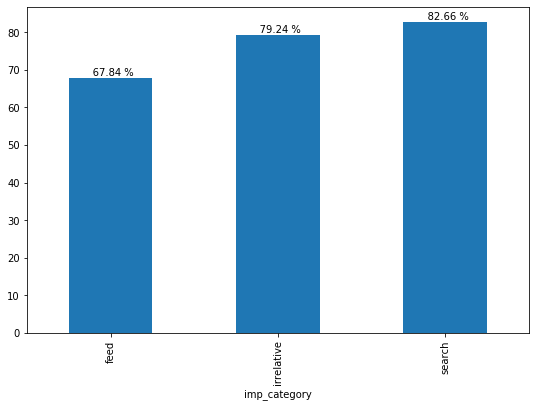

In [34]:
plt.figure(figsize=(9, 6))
summary['coverage%'].plot(kind='bar')
for i, v in enumerate(summary['coverage%']):
    plt.text(i-0.2,v*1.01," "*5+str(v)+' %')
plt.show()

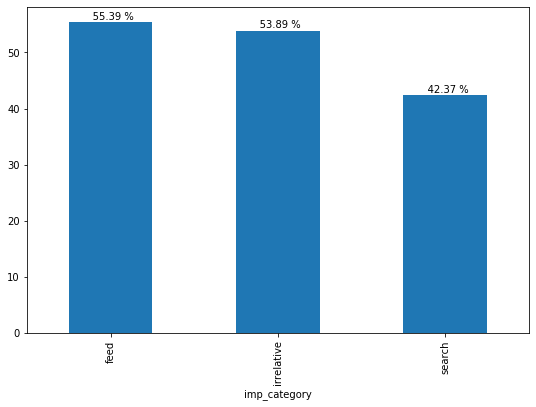

In [35]:
plt.figure(figsize=(9, 6))
summary['impression%'].plot(kind='bar')
for i, v in enumerate(summary['impression%']):
    plt.text(i-0.2,v*1.01," "*5+str(v)+' %')
plt.show()

## Step-6: Further analysis by pos category

In [36]:
df_imp_epc2.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category,rank_category,is_epc_covered,is_pb
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative,Good,1,0
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative,Good,1,0
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative,Good,1,0
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative,Good,1,0
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative,Good,1,0


In [37]:
df_imp_epc_groupby_imp_category = df_imp_epc2.groupby('rank_category')
summary2 = df_imp_epc_groupby_imp_category.agg({"is_epc_covered" : ["count","sum"] ,
                                    'impression' : "sum",
                                    'epc_impression' : "sum"
                                    })
summary2.columns = ['overall_impression_coverage','epc_impression_coverage','overall_impression','epc_impression']
summary2['coverage%'] = round(100*summary2.epc_impression_coverage/summary2.overall_impression_coverage,2)
summary2['impression%'] = round(100*summary2.epc_impression/summary2.overall_impression,2)
summary2

,overall_impression_coverage,epc_impression_coverage,overall_impression,epc_impression,coverage%,impression%
rank_category,,,,,,
Good,3524295,2558329,1505092844,783399280,72.59,52.05
Not_good,9160267,6135564,328435727,164040420,66.98,49.95
OK,5378348,3965310,986181480,506189323,73.73,51.33


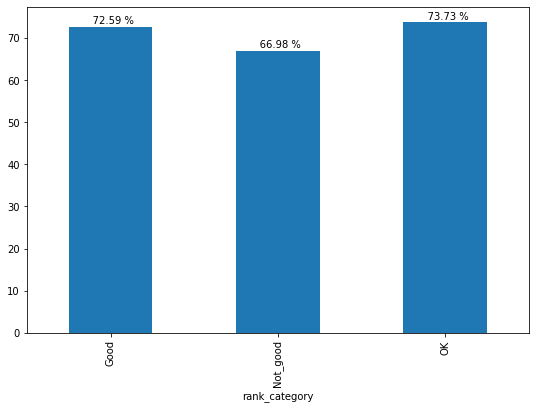

In [38]:
plt.figure(figsize=(9, 6))
summary2['coverage%'].plot(kind='bar')
for i, v in enumerate(summary2['coverage%']):
    plt.text(i-0.2,v*1.01," "*5+str(v)+' %')
plt.show()

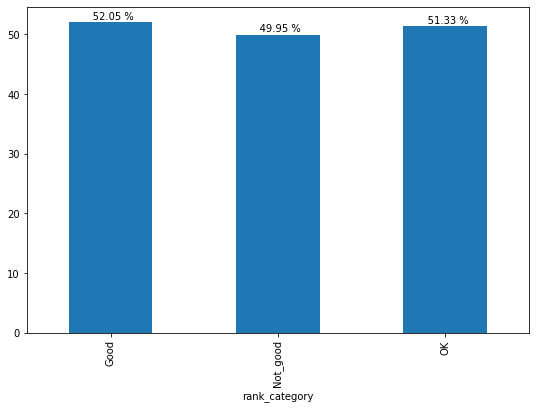

In [39]:
plt.figure(figsize=(9, 6))
summary2['impression%'].plot(kind='bar')
for i, v in enumerate(summary2['impression%']):
    plt.text(i-0.2,v*1.01," "*5+str(v)+' %')
plt.show()

## Step-7: join with position performance metrics data such as CTR, RPM, GMV and so on

In [85]:
#df_imp_epc3 = df_imp_epc2.iloc[:,[1,4,5,6,7,8,9,10,11,12]]
df_imp_epc2.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category,rank_category,is_epc_covered,is_pb
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative,Good,1,0
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative,Good,1,0
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative,Good,1,0
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative,Good,1,0
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative,Good,1,0


In [86]:
df_pos2 = df_pos[df_pos.is_pb == 0]
#df_pos3 = df_pos2.iloc[:,[0,2,4,5,6,7,8,9]]
df_pos2.head()

,pos,source_type,tid,is_pb,total_impression,total_gmv,total_addtocart_freq,total_transaction,total_click_frontend,total_click_backend
0,0,latest,266,0,75096941,6.842181e+05,465197.0,92852.0,3439914.0,3555531.0
2,0,latest,1713,0,152524,7.257557e+02,486.0,100.0,3341.0,3557.0
4,0,others,266,0,6,NaN,NaN,NaN,NaN,NaN
6,0,search,234,0,42276559,1.602049e+06,585757.0,139301.0,3167720.0,3369143.0
8,0,search,235,0,114606,1.612804e+03,280.0,65.0,2413.0,2678.0


In [87]:
df_imp_epc_pos = df_imp_epc2.iloc[:,[1,4,5,6,7,8,9,10,11,12]].merge(df_pos2.iloc[:,[0,2,4,5,6,7,8,9]], how='left', on=['tid','pos'] )

In [90]:
mask = df_imp_epc_pos['total_impression'].notnull()
df_imp_epc_pos = df_imp_epc_pos[mask]
df_imp_epc_pos.head(10)

,tid,client,country_code,pos,impression,epc_impression,imp_category,rank_category,is_epc_covered,is_pb,total_impression,total_gmv,total_addtocart_freq,total_transaction,total_click_frontend,total_click_backend
13751,234,NaN,NaN,36,234,102,search,Good,1,0,22626303.0,111567.722715,60372.0,10830.0,458404.0,457156.0
13752,234,NaN,NaN,40,191,89,search,Good,1,0,19365668.0,89743.531480,50429.0,9135.0,382701.0,381328.0
13753,234,NaN,AE,110,1,1,search,OK,1,0,1041.0,NaN,NaN,NaN,2.0,3.0
13754,234,NaN,AE,192,1,1,search,OK,1,0,290.0,NaN,NaN,NaN,NaN,NaN
13755,234,NaN,AE,28,338,151,search,Good,1,0,30970858.0,151942.570441,83246.0,15086.0,644957.0,646626.0
13756,234,NaN,AE,32,256,103,search,Good,1,0,26226529.0,133528.253670,72564.0,13383.0,551123.0,550988.0
13757,234,NaN,AE,8,450,189,search,Good,1,0,39762453.0,365723.039926,163587.0,32258.0,1187906.0,1214269.0
13758,234,NaN,AG,12,73,34,search,Good,1,0,38514040.0,346636.797459,162667.0,32048.0,1120181.0,1139845.0
13759,234,NaN,AL,44,32,16,search,Good,1,0,15464891.0,68363.508326,39948.0,7049.0,310073.0,308185.0
13760,234,NaN,AM,112,1,0,search,OK,0,0,944.0,NaN,1.0,NaN,3.0,2.0


In [91]:
df_imp_epc_pos_imp_cat = df_imp_epc_pos.groupby('imp_category')

In [93]:
summary3 = df_imp_epc_pos_imp_cat.agg({"is_epc_covered" : ["count","sum"] ,
                                        'impression' : "sum",
                                        'epc_impression' : "sum",
                                        'total_gmv' : 'sum',
                                        'total_transaction' : 'sum'
                                      })
summary3

is_epc_covered            impression epc_impression  \
                      count       sum         sum            sum   
imp_category                                                       
feed               32871811  22680267  3696631623     2048598132   
search               900493    747333   755087561      319944297   

                 total_gmv total_transaction  
                       sum               sum  
imp_category                                  
feed          6.456434e+11      1.029883e+11  
search        1.687349e+10      1.584005e+09

## step-8:join with phash_grouped_products table and see EPC swap strategy potential